### Import packages

In [82]:
import argparse
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pypsa
import re
import pathlib
from pathlib import Path
import numpy as np

### Import data

In [83]:
# Set the paths
base_path = "../../"
#base_path = pathlib.Path(__file__).parent.parent.parent
log_file_dir_path = pathlib.Path(base_path, "logs")
plot_dir_path = pathlib.Path(base_path, "analysis", "plots")
pypsa_earth_path = pathlib.Path(base_path, "workflow", "pypsa-earth")
network_path = pathlib.Path(pypsa_earth_path, "results", "US_2021", "networks", "elec_s_100_ec_lcopt_Co2L-100H.nc")
eia_generation_path = pathlib.Path(base_path, "analysis", "data", "generation_eia.csv")
generation_plot_path = pathlib.Path(plot_dir_path, "electricity_generation.png")
eia_capacity_path = pathlib.Path(base_path, "analysis", "data", "capacities_eia.xlsx")
installed_capacity_plot_path = pathlib.Path(plot_dir_path, "installed_capacity.png")

In [84]:
def extract_time_res(filename):
    # Convert the filename to a string (although you already did this, no need to use network_path.name)
    filename = str(filename)

    # Search for the pattern in the filename
    match = re.search(r'(\d+)(H|SEG)', filename)

    if match:
        number = np.float64(match.group(1))
        unit = match.group(2)

        if unit == 'H':
            return number
        elif unit == 'SEG':
            return 8760 / number
    else:
        return None

filepath = Path(network_path)
time_res = extract_time_res(filepath)
print(time_res)

100.0


In [85]:
# Read reference data
df_eia_generation = pd.read_csv(eia_generation_path, index_col="Unnamed: 0")
df_eia_capacity = pd.read_excel(eia_capacity_path, skiprows=1, index_col="Energy Source")

In [86]:

# Parse argument
year_list = df_eia_generation["Period"].unique().tolist()
parser = argparse.ArgumentParser()
parser.add_argument("--year", help="Year to consider for the comparison", 
                    default=2020, type=int, choices=year_list)

# Modify sys.argv to work in Jupyter/IPython environments
if 'ipykernel_launcher' in sys.argv[0]:
    sys.argv = sys.argv[:1]  # Remove unwanted args

args = parser.parse_args()

# Ensure the logs directory exists
pathlib.Path(log_file_dir_path).mkdir(exist_ok=True)

# Ensure the plots directory exists
pathlib.Path(plot_dir_path).mkdir(exist_ok=True)

In [87]:
df_network = pypsa.Network(network_path)
df_eia_generation_year = df_eia_generation.loc[df_eia_generation["Period"] == args.year].squeeze()

s_max_pu = df_network.lines["s_max_pu"].unique()[0]

/home/user/miniforge3/envs/pypsa-earth/lib/python3.10/site-packages/pypsa/components.py:318: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.

/home/user/miniforge3/envs/pypsa-earth/lib/python3.10/site-packages/pypsa/components.py:318: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.

/home/user/miniforge3/envs/pypsa-earth/lib/python3.10/site-packages/pypsa/components.py:318: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.

/home/user/miniforge3/envs/pypsa-earth/lib/python

In [88]:
df_network.statistics().round(1)

Capacity Factor  Capital Expenditure  \
            carrier                                                      
Generator   Biomass                           1.0         2.504541e+09   
            Coal                              0.8         4.951451e+10   
            Combined-Cycle Gas                0.3         2.372181e+10   
            Csp                               NaN         0.000000e+00   
            Geothermal                        1.0         1.161880e+09   
            Nuclear                           1.0         4.602384e+10   
            Offshore Wind (AC)                NaN         0.000000e+00   
            Offshore Wind (DC)                NaN         0.000000e+00   
            Oil                               0.0         5.043723e+09   
            Onshore Wind                      0.2         2.351957e+10   
            Open-Cycle Gas                    0.0         1.816447e+10   
            Solar                             0.2         7.250205e+09   
Line        AC                                0.1         2.252676e+10   
Link        B2B                               0.7         0.000000e+00   
            Csp                               NaN         0.000000e+00   
            DC                                0.6         3.410907e+09   
            H2 electrolysis                   NaN         0.000000e+00   
            H2 fuel cell                      NaN         0.000000e+00   
            battery charger                   NaN         0.000000e+00   
            battery discharger                NaN         0.000000e+00   
Load        -                                 NaN                  NaN   
StorageUnit Pumped Hydro Storage              0.0         3.532078e+09   
            Reservoir & Dam                   0.3         0.000000e+00   
Store       Battery Storage                   NaN         0.000000e+00   
            Csp                               NaN         0.000000e+00   
            Hydrogen Storage                  NaN         0.000000e+00   

                                  Curtailment      Dispatch  \
            carrier                                           
Generator   Biomass                       0.0  5.923433e+07   
            Coal                          0.0  1.458099e+09   
            Combined-Cycle Gas            0.0  8.639038e+08   
            Csp                           0.0  0.000000e+00   
            Geothermal                    0.0  3.473515e+07   
            Nuclear                       0.0  8.693706e+08   
            Offshore Wind (AC)            0.0  0.000000e+00   
            Offshore Wind (DC)            0.0  0.000000e+00   
            Oil                           0.0  2.642107e+06   
            Onshore Wind            2651253.9  2.939944e+08   
            Open-Cycle Gas                0.0  6.637243e+07   
            Solar                     32838.2  9.651276e+07   
Line        AC                            NaN -6.953367e+07   
Link        B2B                           NaN  1.365047e+07   
            Csp                           NaN  0.000000e+00   
            DC                            NaN -5.608898e+06   
            H2 electrolysis               NaN  0.000000e+00   
            H2 fuel cell                  NaN  0.000000e+00   
            battery charger               NaN  0.000000e+00   
            battery discharger            NaN  0.000000e+00   
Load        -                             NaN -3.988187e+09   
StorageUnit Pumped Hydro Storage          0.0  0.000000e+00   
            Reservoir & Dam               0.0  2.433216e+08   
Store       Battery Storage               NaN  0.000000e+00   
            Csp                           NaN  0.000000e+00   
            Hydrogen Storage              NaN  0.000000e+00   

                                  Installed Capacity  Market Value  \
            carrier                                                  
Generator   Biomass                           6798.4    

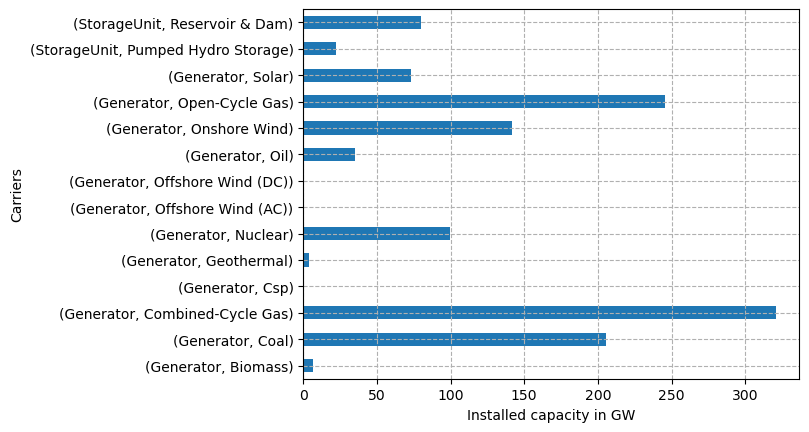

In [89]:
stats = df_network.statistics().round(1)["Installed Capacity"] / 1e3
installed_cap = stats.loc[["Generator","StorageUnit"]]
# installed_cap = installed_cap.drop(('Generator','load'))
installed_cap.plot(kind='barh')
plt.xlabel("Installed capacity in GW")
plt.ylabel("Carriers")
plt.grid(linestyle='--')

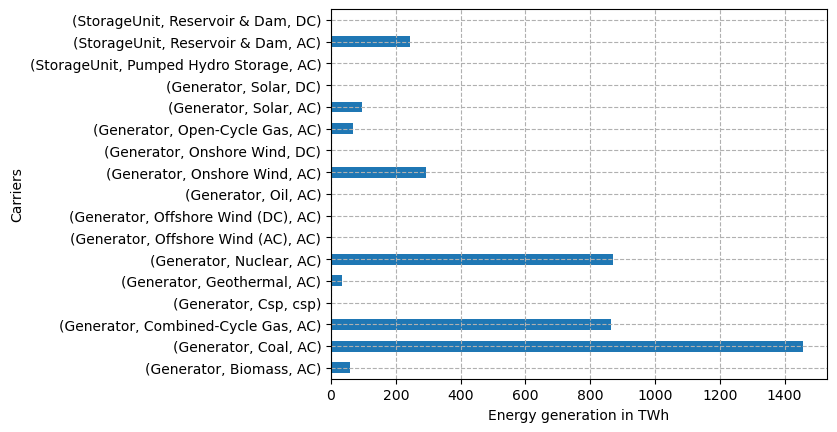

In [90]:
stats = df_network.statistics.energy_balance() / 1e6
energy_gen = stats.loc[["Generator","StorageUnit"]]
# energy_gen = energy_gen.drop(('Generator','load'))
energy_gen.plot(kind='barh')
plt.xlabel("Energy generation in TWh")
plt.ylabel("Carriers")
plt.grid(linestyle='--')

In [91]:
df_network.generators = df_network.generators.assign(p = df_network.generators_t.p.sum() * time_res)
df_pypsa = df_network.generators.groupby("carrier").p.sum()
df_pypsa.loc['wind'] = df_pypsa.loc[["offwind-ac","offwind-dc","onwind"]].sum()
df_pypsa = df_pypsa.drop(["offwind-ac","offwind-dc","onwind"])
df_pypsa /= 1e6
df_pypsa = df_pypsa.round(2)
df_pypsa.name = 'pypsa'

In [92]:
# Initial configurations
eia_name = "EIA"
pypsa_name = "PyPSA"

# Electricity generation comparison

## Installed capacity

In [93]:
# ---> Prepare the PyPSA results
df_pypsa_hydro_phs_capacity = df_network.storage_units.groupby("carrier").p_nom_opt.sum()
df_pypsa_capacity = pd.concat([df_network.generators.groupby("carrier").p_nom_opt.sum(), df_pypsa_hydro_phs_capacity])
df_pypsa_capacity.loc["wind"] = df_pypsa_capacity.loc[["offwind-ac", "offwind-dc", "onwind"]].sum()
df_pypsa_capacity = df_pypsa_capacity.drop(["offwind-ac", "offwind-dc", "onwind"])
df_pypsa_capacity /= 1000
df_pypsa_capacity = df_pypsa_capacity.round(2)
df_pypsa_capacity.name = pypsa_name

df_pypsa_capacity

carrier
CCGT          320.68
OCGT          245.55
biomass         6.80
coal          205.45
csp             0.00
geothermal      3.97
nuclear        99.44
oil            35.42
solar          73.11
PHS            21.99
hydro          79.83
wind          141.74
Name: PyPSA, dtype: float64

In [94]:
# ---> Prepare the EIA reference data
df_eia_capacity.index = df_eia_capacity.index.str.lower()
df_eia_capacity.loc["other biomass"] = df_eia_capacity.loc[["other biomass", "wood and wood-derived fuels"]].sum()
df_eia_capacity = df_eia_capacity.rename(index={"hydroelectric conventional": "hydro", "hydroelectric pumped storage": "PHS" , "solar photovoltaic": "solar", "natural gas": "CCGT", "petroleum": "oil", "other biomass": "biomass"})
df_eia_capacity = df_eia_capacity.drop(["estimated total solar", "solar thermal", "wood and wood-derived fuels", "other energy sources", "total", "small scale photovoltaic", "estimated total photovoltaic", "other gases",])
df_eia_capacity = df_eia_capacity.iloc[:-1]
df_eia_capacity.loc["solar", "Generator Nameplate Capacity"] = df_eia_capacity.loc["solar", "Net Summer Capacity"]
df_eia_capacity = df_eia_capacity["Generator Nameplate Capacity"]
df_eia_capacity.name = eia_name
df_eia_capacity /= 1000


In [95]:
# ---> Prepare comparison dataframe
df_compare_capacity = pd.concat([df_pypsa_capacity, df_eia_capacity], axis=1)

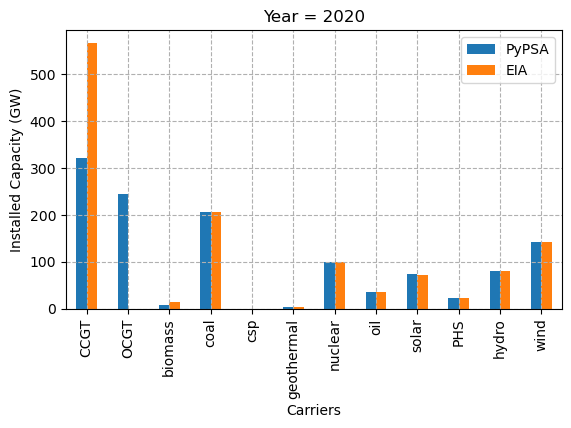

In [96]:
df_compare_capacity.plot(kind="bar")
plt.xlabel("Carriers")
plt.ylabel("Installed Capacity (GW)")
plt.title(f"Year = {args.year}")
plt.grid(linestyle="--")
plt.subplots_adjust(bottom=0.3)
plt.savefig(installed_capacity_plot_path, dpi=800)

In [97]:
df_compare_capacity.sum()

PyPSA      1233.98
EIA      1239.3987
dtype: object

## Total Electricity Demand in TWh

In [98]:
df_network.loads_t.p.sum().sum() * time_res / 1e6

4005.935306641992

## Total Electricity Generation in TWh

In [99]:
df_network.generators_t.p.sum().sum() * time_res / 1e6

3761.6198570105103

# Dispatch timeseries in GW

In [100]:
def plot_dispatch(n, time="2015-07"):

    # if not n.links.empty:
    #     links = (
    #         n.links_t.p1.groupby(n.links.carrier, axis=1).sum().div(1e3) * -1
    #     )
    #     links = links[conv_carriers]
    #     p_by_carrier = links
    n.carriers.loc['load','color'] = 'black'
    carrier_order = ["nuclear","CCGT","OCGT","oil","coal","solar","onwind","offwind-ac","offwind-dc","geothermal","biomass"]
    gen_car = n.generators.query('carrier != "load"').carrier.unique()
    generators = n.generators_t.p.groupby(n.generators.carrier, axis=1).sum().div(1e3)
    p_by_carrier = generators[carrier_order]

    if not n.storage_units.empty:
        sto = (
            n.storage_units_t.p.groupby(n.storage_units.carrier, axis=1).sum().div(1e3)
        )
        p_by_carrier = pd.concat([p_by_carrier, sto], axis=1)

    fig, ax = plt.subplots(figsize=(6, 3))

    color = p_by_carrier.columns.map(n.carriers.color)

    p_by_carrier.where(p_by_carrier > 0).loc[time].plot.area(
        ax=ax,
        linewidth=0,
        color=color,
    )

    charge = p_by_carrier.where(p_by_carrier < 0).dropna(how="all", axis=1).loc[time]

    if not charge.empty:
        charge.plot.area(
            ax=ax,
            linewidth=0,
#             color=charge.columns.map(n.carriers.color)
        )

    n.loads_t.p_set.sum(axis=1).loc[time].div(1e3).plot(ax=ax, c="k",linewidth=0.1)

    plt.legend(loc=(1.05, 0),fontsize=8)
    handles = ax.legend_.legendHandles
    labels = [elt.get_text() for elt in ax.legend_.texts]
    ax.legend(handles[::-1], labels[::-1], loc='upper left', bbox_to_anchor=(1, 1.1))
    ax.set_ylabel("GW")
    ax.set_ylim(-5, 1000)
#     plt.subplots_adjust(right=0.8)
    ax.grid(linestyle="--")

In [101]:
df_network.generators.query('carrier != "load"').carrier.unique()

array(['CCGT', 'OCGT', 'biomass', 'coal', 'csp', 'oil', 'onwind', 'solar',
       'nuclear', 'offwind-ac', 'offwind-dc', 'geothermal'], dtype=object)

/tmp/ipykernel_143364/3694781424.py:12: FutureWarning:

DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.

/tmp/ipykernel_143364/3694781424.py:17: FutureWarning:

DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.



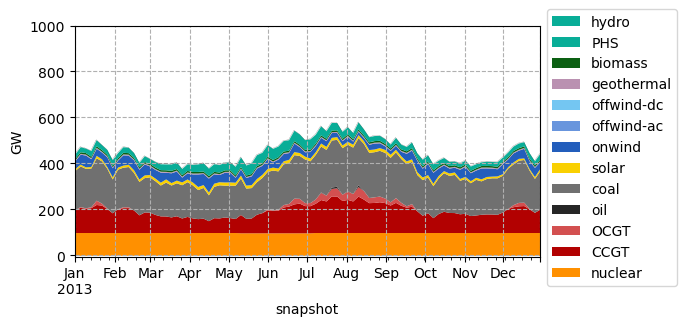

In [102]:
plot_dispatch(df_network,"2013")

In [103]:
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
from matplotlib.patches import Patch

def add_legend_patches(ax, colors, labels, legend_kw):
    patches = [Patch(color=color, label=label) for color, label in zip(colors, labels)]
    ax.legend(handles=patches, **legend_kw)


def plot_map(n, plot_type, key):
    carriers = n.carriers.index.tolist()[:-2]
    buses = n.buses.query('carrier == "AC" and index != "US0 7"')
    bus_index = buses.index.tolist()
    fig = plt.figure(figsize=(15,12))
    ax = plt.axes(projection=ccrs.EqualEarth())
    n.lines.loc[n.lines.bus0 == 'US0 19','s_nom'] = 0

    if plot_type == "capacity":
        cap = n.generators.query("carrier != 'load' and bus in @bus_index").groupby(["bus", "carrier"]).p_nom.sum()
        cap = cap[cap.index.get_level_values('bus') != 'US0 19']

        # Filter carriers with positive capacity, and avoid KeyError by checking presence in index
        carriers_with_capacity = []
        for carrier in carriers:
            if carrier in cap.index.get_level_values('carrier'):
                total_capacity = cap.xs(carrier, level='carrier').sum()
                if total_capacity > 0:
                    carriers_with_capacity.append(carrier)

        n.plot(
            ax=ax,
            bus_sizes=cap / 2e4,
            line_widths=n.lines.s_nom / 1e4,
            line_colors='rosybrown',
            margin=0.25,
            bus_alpha=0.8,
            color_geomap=True,
            link_alpha=0
        )

        values = n.generators.query("carrier != 'load' and bus in @bus_index").groupby("bus").p_nom.sum()
        sizes = np.sort(round(values / 1e3).unique() * 1e3 / 2e4)
        labels = np.sort(round(values / 1e3).unique())
        title = "Capacity (GW)"
        x_val = 1.25

        # Add the legend with filtered carriers
        add_legend_patches(
            ax, 
            colors=[n.carriers.loc[carrier].color for carrier in carriers_with_capacity], 
            labels=carriers_with_capacity, 
            legend_kw=dict(frameon=False, bbox_to_anchor=(0, 1), title="Carriers")
        )
        
    # Additional features like coastlines and borders
    #ax.add_feature(LAND)
    #ax.coastlines()
    #ax.add_feature(BORDERS, alpha=1, edgecolor='black')


/home/user/miniforge3/envs/pypsa-earth/lib/python3.10/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning:

facecolor will have no effect as it has been defined as "never".



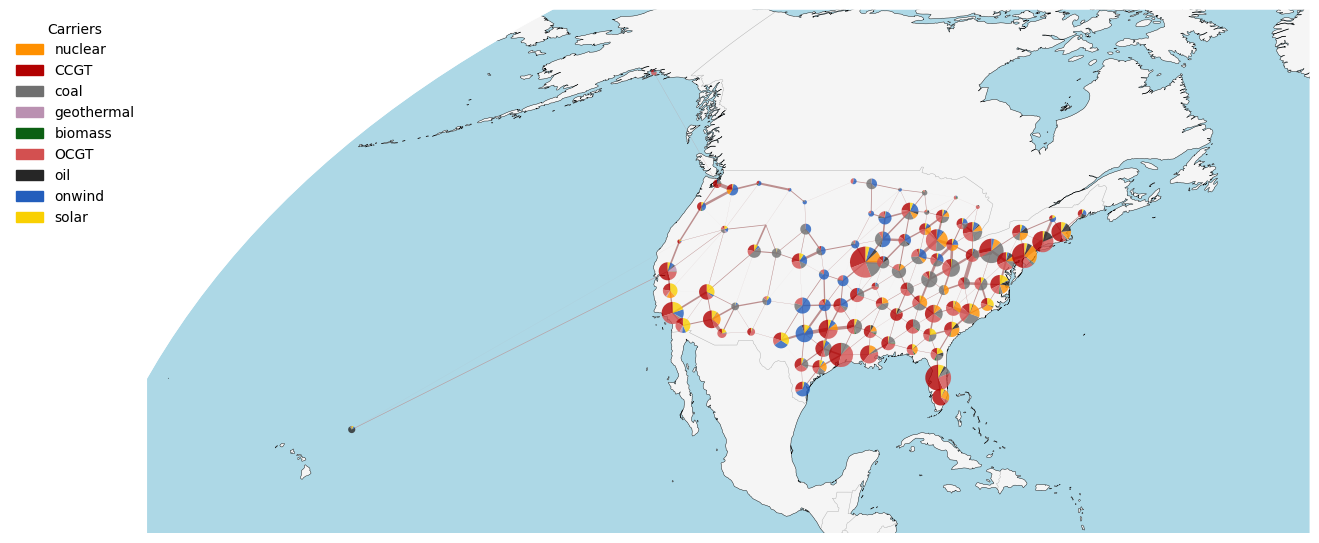

In [104]:
plot_map(df_network,"capacity","")

# Demand timeseries in GW

<AxesSubplot:xlabel='snapshot'>

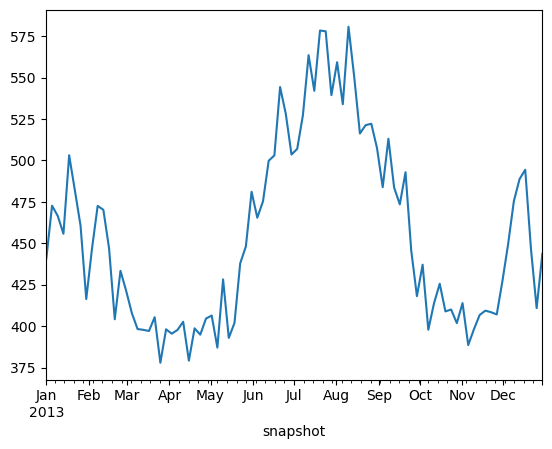

In [105]:
(df_network.loads_t.p_set.sum(axis=1) / 1e3).plot()

# Generation timeseries in GW

<AxesSubplot:xlabel='snapshot'>

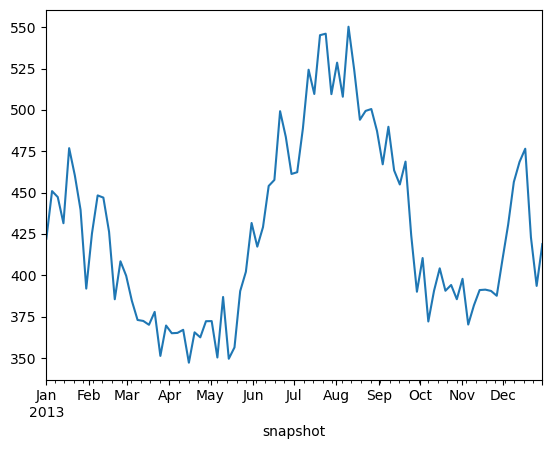

In [106]:
(df_network.generators_t.p.sum(axis=1) / 1e3).plot()

In [107]:
df_eia_monthly = pd.read_csv("../data/monthly_generation_US.csv",skiprows=4)
df_eia_monthly = df_eia_monthly.dropna(axis=0)
# df_eia_monthly = df_eia
df_eia_monthly.sort_index(ascending=False)[1:-1].reset_index()

,index,Month,all fuels (utility-scale) thousand megawatthours,coal thousand megawatthours,natural gas thousand megawatthours,nuclear thousand megawatthours,conventional hydroelectric thousand megawatthours,other renewables thousand megawatthours,hydro-electric pumped storage thousand megawatthours,other gases thousand megawatthours,petroleum liquids thousand megawatthours
0,22,Jan 2021,180728.45032,66231.49971,53913.46978,34339.450,18611.53183,6207.66901,-339.236,5.19332,1188.16274
1,21,Feb 2021,163642.61950,46241.08298,53745.50684,35324.705,18970.96776,8346.53567,-141.503,8.61941,599.04253
2,18,Mar 2021,151505.03330,40783.61682,54242.56159,30125.961,17255.70913,8281.45845,-101.948,-0.38473,611.02053
3,17,Apr 2021,170418.81556,49416.68259,57584.38116,33490.728,21177.86466,8037.76082,-322.855,-0.28468,635.12736
4,14,May 2021,207175.70902,66423.90191,74851.67559,36854.337,21826.51122,6434.49710,-269.964,-0.27507,671.97540
5,13,Jun 2021,226361.26789,76451.54978,84946.61256,38370.528,20109.28476,5808.25001,-550.845,-0.26008,652.04572
6,10,Jul 2021,227826.91444,77465.31171,85233.24209,38751.840,18598.49465,6727.14729,-531.015,-0.27507,935.49064
7,9,Aug 2021,185991.21152,60310.64295,66831.68497,35305.664,15288.52205,7301.00061,-313.409,0.00000,740.36142
8,8,Sep 2021,166407.27799,45722.47543,62206.18236,34522.285,15382.67232,7659.95553,-333.460,0.00000,690.40235
9,5,Oct 2021,162701.85066,41645.58231,58942.31276,34882.319,17372.67955,8852.16839,-301.523,0.00000,647.13462


In [108]:
df_pypsa_grouped = df_network.generators_t.p.groupby(df_network.generators.carrier,axis=1).sum() * time_res
df_pypsa_monthly = df_pypsa_grouped.groupby(df_pypsa_grouped.index.month).sum()
df_pypsa_monthly = df_pypsa_monthly.sum(axis=1).div(1e6)
df_pypsa_monthly.name = 'PyPSA'
df_pypsa_monthly.index = np.arange(0,12)
df_pypsa_monthly

/tmp/ipykernel_143364/2443958026.py:1: FutureWarning:

DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.



0     352.038392
1     294.040328
2     259.856959
3     254.428885
4     303.941247
5     320.222576
6     358.587636
7     409.227788
8     315.815002
9     274.748898
10    311.970899
11    306.741247
Name: PyPSA, dtype: float64

In [109]:
df_eia = pd.read_excel("../data/Table_7.2a_Electricity_Net_Generation__Total_(All_Sectors).xlsx",skiprows=10)
df_eia_monthly_2021 = df_eia.loc[df_eia.Month.dt.year == 2021].reset_index()
df_eia_monthly_2021 = df_eia_monthly_2021["Electricity Net Generation Total (including from sources not shown), All Sectors"]
df_eia_monthly_2021 = df_eia_monthly_2021 / 1000
# df_eia_monthly_2021 = df_eia_monthly_2021.reset_index()
df_eia_monthly_2021.name = 'EIA'
df_eia_monthly_2021

0     349.209709
1     323.899529
2     311.397276
3     293.307944
4     320.180962
5     373.856478
6     405.624091
7     412.864768
8     347.743775
9     320.201778
10    314.309521
11    337.103561
Name: EIA, dtype: object

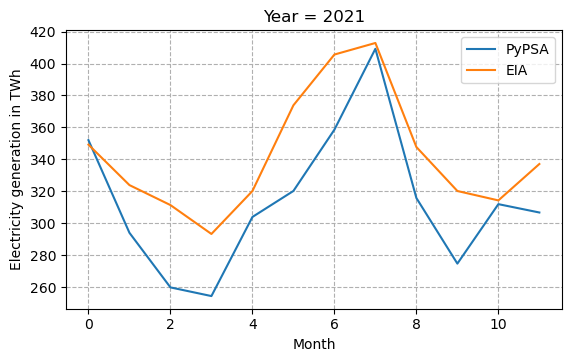

In [110]:
df_compare_gen_ts = pd.concat([df_pypsa_monthly,df_eia_monthly_2021],axis=1)
df_compare_gen_ts.plot()
plt.xlabel('Month')
plt.ylabel('Electricity generation in TWh')
plt.title('Year = 2021')
plt.grid(linestyle='--')
plt.subplots_adjust(bottom=0.3)
plt.savefig("../plots/electricity_gen_ts.png",dpi=800)

In [111]:
df_eia = pd.read_excel("../data/Table_7.6_Electricity_End_Use_and_Electric_Vehicle_Use.xlsx",skiprows=10)
df_eia_monthly_2021 = df_eia.loc[df_eia.Month.dt.year == 2021].reset_index()
df_eia_monthly_2021 = df_eia_monthly_2021["Electricity End Use, Total"]
# df_eia_monthly_2021 = df_eia_monthly_2021["Electricity Sales to Ultimate Customers, Total"]
df_eia_monthly_2021 = df_eia_monthly_2021 / 1000
# # df_eia_monthly_2021 = df_eia_monthly_2021.reset_index()
df_eia_monthly_2021.name = 'EIA'
df_eia_monthly_2021

0      333.97653
1     309.816283
2     306.272657
3      283.32879
4     301.122292
5     350.199269
6     386.625923
7     393.627941
8     347.832293
9     313.613342
10    298.838866
11    319.535135
Name: EIA, dtype: object

In [112]:
df_eia = pd.read_excel("../data/Table_7.6_Electricity_End_Use_and_Electric_Vehicle_Use.xlsx",skiprows=10)
df_eia_monthly_2020 = df_eia.loc[df_eia.Month.dt.year == 2020].reset_index()
df_eia_monthly_2020 = df_eia_monthly_2020["Electricity End Use, Total"]
df_eia_monthly_2020 = df_eia_monthly_2020 / 1000
# # df_eia_monthly_2021 = df_eia_monthly_2021.reset_index()
df_eia_monthly_2020.name = 'EIA 2020'
df_eia_monthly_2020

0     328.246135
1     306.425243
2       301.7527
3     273.132424
4     285.627076
5     331.355301
6     391.577954
7     380.979969
8     333.682753
9     307.869372
10    288.228154
11    327.499941
Name: EIA 2020, dtype: object

In [113]:
df_pypsa_grouped = df_network.loads_t.p.sum(axis=1) * time_res
df_pypsa_monthly = df_pypsa_grouped.groupby(df_pypsa_grouped.index.month).sum()
df_pypsa_monthly = df_pypsa_monthly.div(1e6)
df_pypsa_monthly.name = 'PyPSA'
df_pypsa_monthly.index = np.arange(0,12)
df_pypsa_monthly

0     369.840557
1     309.578991
2     278.324689
3     277.402467
4     338.441540
5     351.971475
6     383.529143
7     429.133102
8     331.115923
9     289.587884
10    326.035911
11    320.973624
Name: PyPSA, dtype: float64

In [114]:
# df_bev = pd.read_csv("../data/demand_BEV.csv")
df_bev = pd.read_csv("../data/demand_basegrid.csv")
df_bev = df_bev.set_index("UTC Time")
df_bev_monthly = df_bev.groupby(pd.to_datetime(df_bev.index).month).sum()
# df_bev_monthly = df_bev_monthly.sum() 
df_bev_monthly = df_bev_monthly.sum(axis=1)
df_bev_monthly = df_bev_monthly / 1e6
df_bev_monthly.name = 'BEV'
df_bev_monthly.index = np.arange(0,12)
df_bev_monthly


0     346.611661
1     307.499217
2     299.358134
3     286.032168
4     309.570943
5     361.636612
6     405.939259
7     402.971036
8     345.669695
9     307.225100
10    292.291317
11    339.831745
Name: BEV, dtype: float64

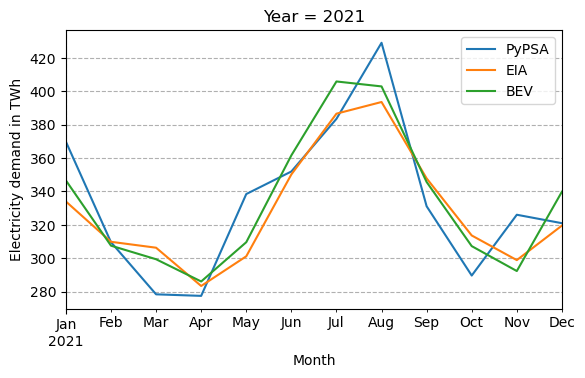

In [115]:
df_compare_dem_ts = pd.concat([df_pypsa_monthly,df_eia_monthly_2021,df_bev_monthly],axis=1)
df_compare_dem_ts.index = df_eia.loc[df_eia.Month.dt.year == 2021].Month.tolist()
df_compare_dem_ts.plot()
plt.xlabel('Month')
plt.ylabel('Electricity demand in TWh')
plt.title('Year = 2021')
plt.grid(linestyle='--')
plt.subplots_adjust(bottom=0.3)
plt.savefig("../plots/electricity_demand_ts.png",dpi=800)

In [116]:
df_network.generators.loc[df_network.generators['carrier'] == 'coal']

,p_nom_max,weight,p_nom,capital_cost,efficiency,p_nom_min,marginal_cost,bus,carrier,control,...,shut_down_cost,min_up_time,min_down_time,up_time_before,down_time_before,ramp_limit_up,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down,p
Generator,,,,,,,,,,,,,,,,,,,,,
US0 0 coal,inf,0.0,2673.0,241010.093971,0.464,2673.0,10.614014,US0 0,coal,,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,22262870.00
US0 1 coal,inf,0.0,2215.8,241010.093971,0.464,2215.8,10.613625,US0 1,coal,,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,19499040.00
US0 12 coal,inf,0.0,700.0,241010.093971,0.464,700.0,10.612981,US0 12,coal,,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,5731653.45
US0 13 coal,inf,0.0,5002.4,241010.093971,0.464,5002.4,10.612317,US0 13,coal,,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,43290551.00
US0 14 coal,inf,0.0,4213.9,241010.093971,0.464,4213.9,10.613912,US0 14,coal,,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,37010832.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
US0 94 coal,inf,0.0,3081.3,241010.093971,0.464,3081.3,10.613496,US0 94,coal,,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,3646252.69
US0 95 coal,inf,0.0,2547.0,241010.093971,0.464,2547.0,10.613453,US0 95,coal,,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,22158900.00
US0 96 coal,inf,0.0,3610.6,241010.093971,0.464,3610.6,10.612131,US0 96,coal,,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,29825903.00


In [117]:
generators = df_network.generators
coal_gas_plants = generators[generators['carrier'].isin(['CCGT', 'coal'])]
grouped_coal_gas_plants = coal_gas_plants.groupby('bus').apply(
    lambda x: pd.DataFrame({
        'indices': x.index.tolist(),
        'p_nom': x['p_nom'].tolist()
    })
).reset_index(level=1, drop=True)

grouped_coal_gas_plants 


/tmp/ipykernel_143364/2718332946.py:3: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



,indices,p_nom
bus,,
US0 0,US0 0 CCGT,2318.7
US0 0,US0 0 coal,2673.0
US0 1,US0 1 CCGT,84.0
US0 1,US0 1 coal,2215.8
US0 10,US0 10 CCGT,705.4
...,...,...
US0 96,US0 96 coal,3610.6
US0 97,US0 97 CCGT,1548.2
US0 98,US0 98 coal,15.5


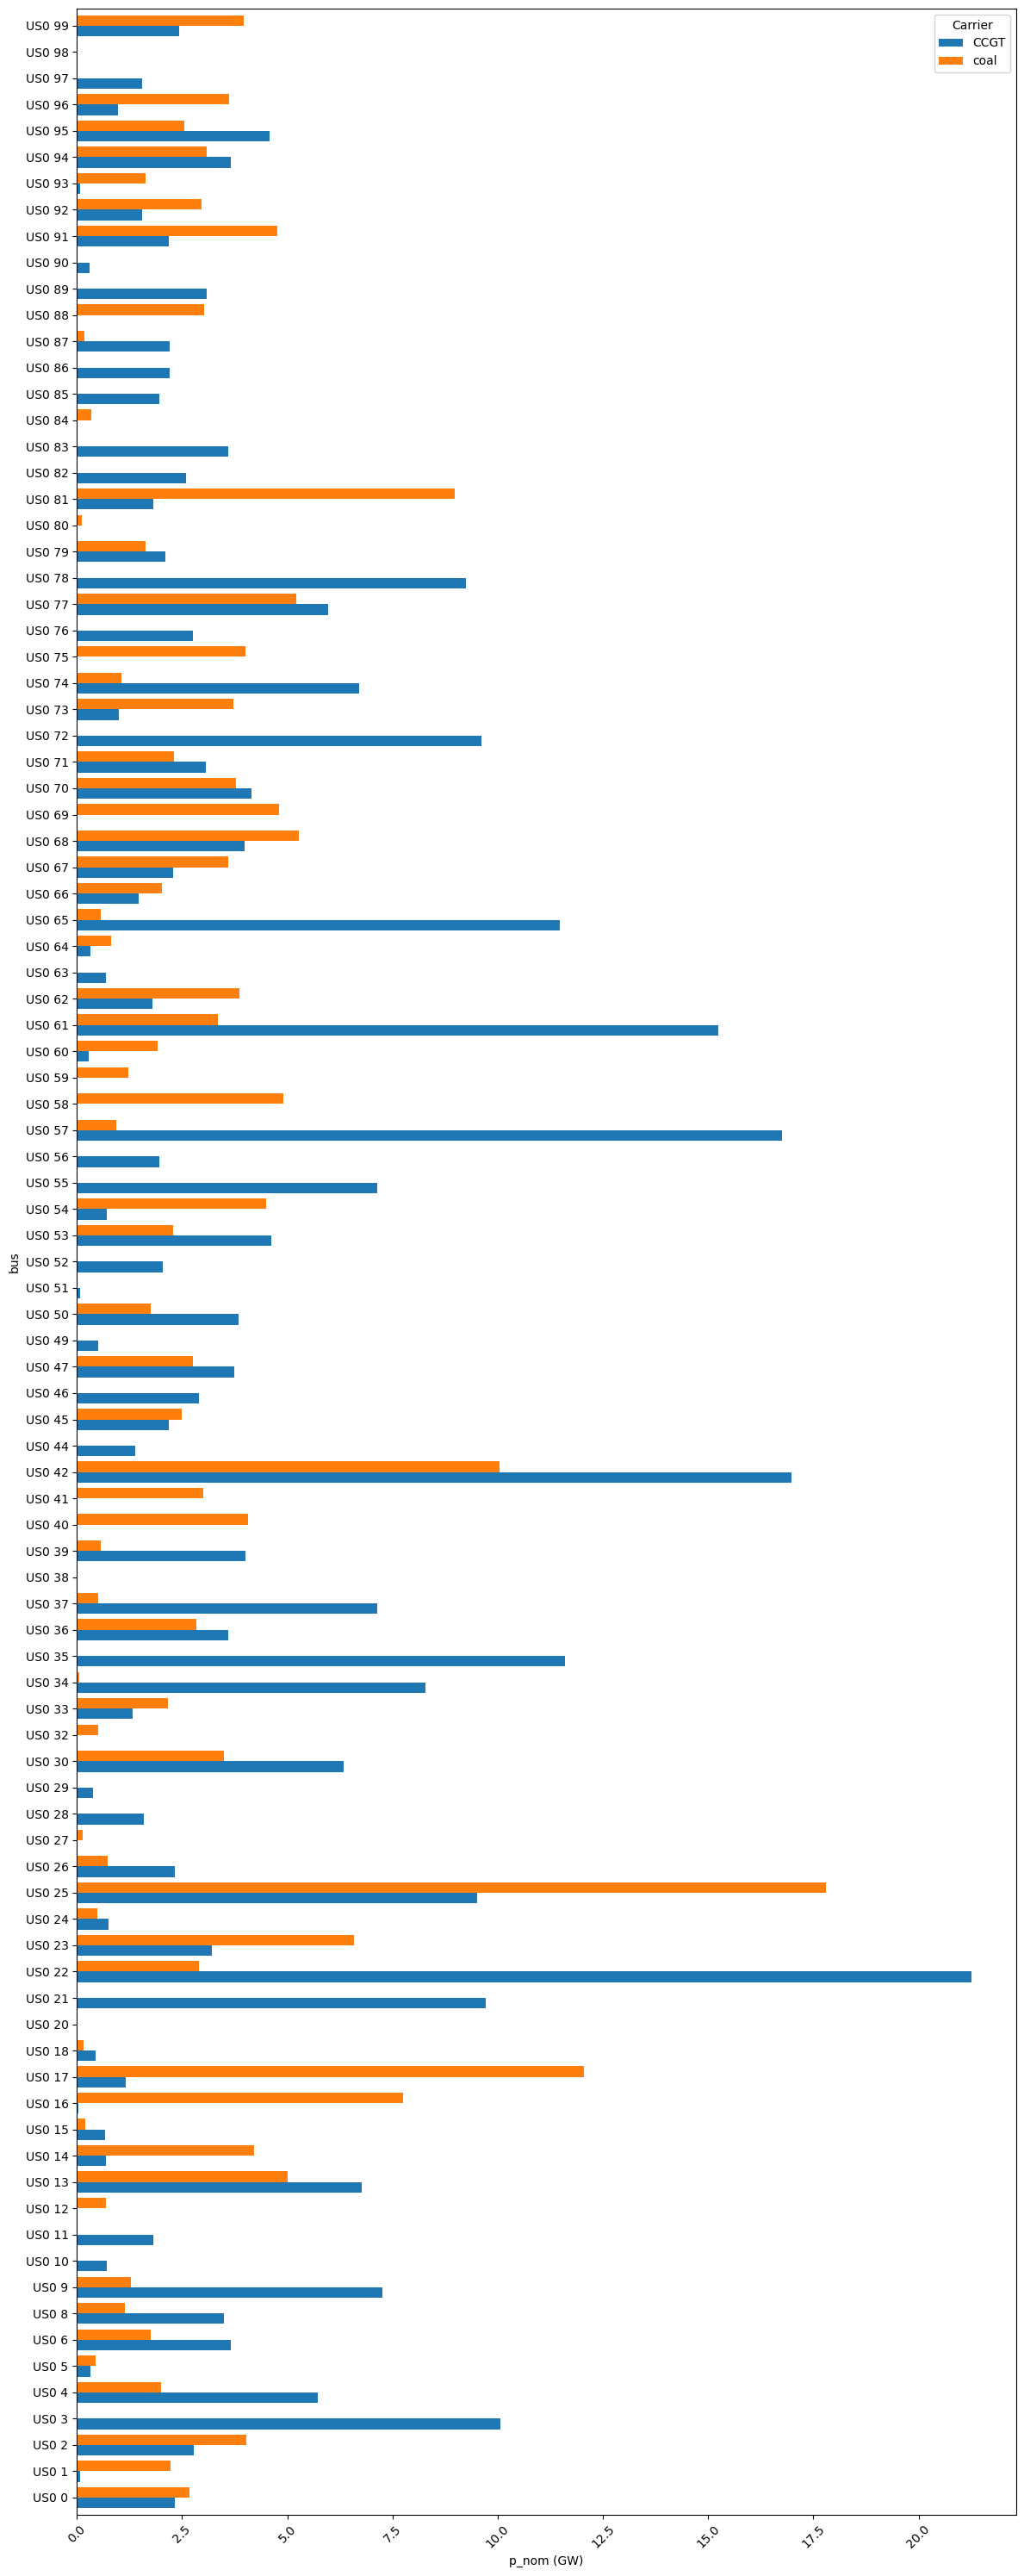

In [123]:
summary = coal_gas_plants.groupby(['bus', 'carrier'])['p_nom'].sum().div(1e3).unstack(fill_value=0)
summary = summary.reindex(sorted(summary.index, key=lambda x: int(x[3:])), axis=0)

summary.plot(kind='barh', figsize=(12, 30), width=0.8)

plt.xlabel('p_nom (GW)')
plt.ylabel('bus')
plt.legend(title='Carrier')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

#fig.savefig('../plots/coal_ccgt_comparison.pdf', dpi=1000)

# CO2 emissions in Mtonnes

In [119]:
e = (
    df_network.generators_t.p
    / df_network.generators.efficiency
    * df_network.generators.carrier.map(df_network.carriers.co2_emissions)
)
emissions = df_network.snapshot_weightings.generators @ e.sum(axis=1).div(1e6)

In [120]:
emissions

1472.7999914901966